**Explanation**

## Bipartite Ranking Algorithm
This notebook implements a bipartite ranking algorithm that ranks items based on user ratings while iteratively refining user reputations. The goal is to achieve a fair ranking system where user biases are minimized.

### **How it Works**
1. **Initialize User Reputation**: All users start with equal reputation.
2. **Compute Item Rankings**: Item scores are calculated using weighted user ratings.
3. **Update User Reputation**: Users with large rating errors are penalized.
4. **Iterate Until Convergence**: The process is repeated until rankings stabilize.

This notebook will:
- Load the dataset.
- Apply the bipartite ranking algorithm.
- Visualize the resulting item rankings.




**1.    Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

**2.    Load Dataset**


In [21]:
# Define dataset path
# Define dataset path
file_path = "/home/martimsbaltazar/Desktop/tese/datasets/ml-1m/normalized_ratings.dat"

# Load dataset
df = pd.read_csv(file_path, sep="::", engine="python", names=["UserID", "MovieID", "Rating", "Timestamp", "NormalizedRating"])

# Display first few rows
df.head()

# Step 2: Get unique users and items
all_users = set(df["UserID"].unique())
items = df["MovieID"].unique()
# Display first few rows
df.head()


,UserID,MovieID,Rating,Timestamp,NormalizedRating
0,1,1193,5,978300760,1.0
1,1,661,3,978302109,0.6
2,1,914,3,978301968,0.6
3,1,3408,4,978300275,0.8
4,1,2355,5,978824291,1.0


**3.    Bipartite Ranking Algorithm**

In [9]:
def bipartite_ranking_algorithm(df, lambda_factor=0.3, tol=1e-6, max_iter=50):
    users = df["UserID"].unique()
    items = df["MovieID"].unique()

    # Step 1: Initialize user reputations (equal for all users)
    user_reputation = {user: 1.0 for user in users}
    
    for iteration in range(max_iter):
        prev_item_rankings = {} if iteration == 0 else item_rankings.copy()

        # Step 2: Update item rankings
        item_rankings = {}
        for item in items:
            item_ratings = df[df["MovieID"] == item]  # Ratings given to a specific movie
            users_who_rated = item_ratings["UserID"].values  # Users who rated this movie
            
            if len(users_who_rated) == 0:
                continue
            
            # Step 3: Compute weighted sum of ratings using user reputation
            weighted_sum = sum(
                float(user_reputation[u]) * float(r)
                for u, r in zip(users_who_rated, item_ratings["NormalizedRating"].values)
            )
            total_weight = len(users_who_rated)
            
            # Step 4: Assign ranking to item
            item_rankings[item] = weighted_sum / total_weight if total_weight > 0 else 0
        
        # Step 5: Update user reputations
        for user in users:
            user_ratings = df[df["UserID"] == user]
            items_rated = user_ratings["MovieID"].values
            
            if len(items_rated) == 0:
                continue
            
            # Step 6: Compute average rating error
            rating_errors = [
                abs(r - item_rankings[i]) for i, r in zip(items_rated, user_ratings["NormalizedRating"].values)
                if i in item_rankings
            ]
            if not rating_errors:
                continue

            avg_error = sum(rating_errors) / len(rating_errors)
            
            # Step 7: Update user reputation
            user_reputation[user] = 1 - lambda_factor * avg_error
            user_reputation[user] = max(user_reputation[user], 0)  # Ensure non-negative reputation
        
        # Step 8: Check for convergence
        if iteration > 0:
            ranking_diff = sum(
                abs(prev_item_rankings[i] - item_rankings[i])
                for i in items if i in prev_item_rankings and i in item_rankings
            )
            if ranking_diff < tol:
                break

    return item_rankings, user_reputation



**4. Compute Item Rankings**


In [11]:
# Compute rankings using the bipartite ranking algorithm
rankings, userReputation = bipartite_ranking_algorithm(df)

print(userReputation)


{1: 0.957362469837031, 2: 0.9565338879635908, 3: 0.9496458236875432, 4: 0.9490133407457388, 5: 0.9456937003444884, 6: 0.9517974865628581, 7: 0.9473564347270585, 8: 0.9540665092281909, 9: 0.9661412050860289, 10: 0.9431756684772581, 11: 0.9413379393657398, 12: 0.9552523098633576, 13: 0.9691075922608534, 14: 0.940656756133894, 15: 0.9627135162284773, 16: 0.9520918225465905, 17: 0.9556060447203583, 18: 0.9422937143416237, 19: 0.9513032442978229, 20: 0.9582758247547156, 21: 0.9258723308286223, 22: 0.9551556692577315, 23: 0.9491388492431326, 24: 0.963282421787015, 25: 0.9419139244793096, 26: 0.9493307283546865, 27: 0.9505336308062343, 28: 0.9637123148995872, 29: 0.9467843060824042, 30: 0.9529360022463947, 31: 0.951777506843334, 32: 0.9545251331351018, 33: 0.9499525931760142, 34: 0.9497313200127471, 35: 0.9563837031748957, 36: 0.9488745958859224, 37: 0.9309141421100475, 38: 0.965575338728668, 39: 0.9480501732302091, 40: 0.9569336155656363, 41: 0.9260635649950967, 42: 0.957991428306969, 43: 0.

**5. Visualizing the Distribution of Item Rankings**

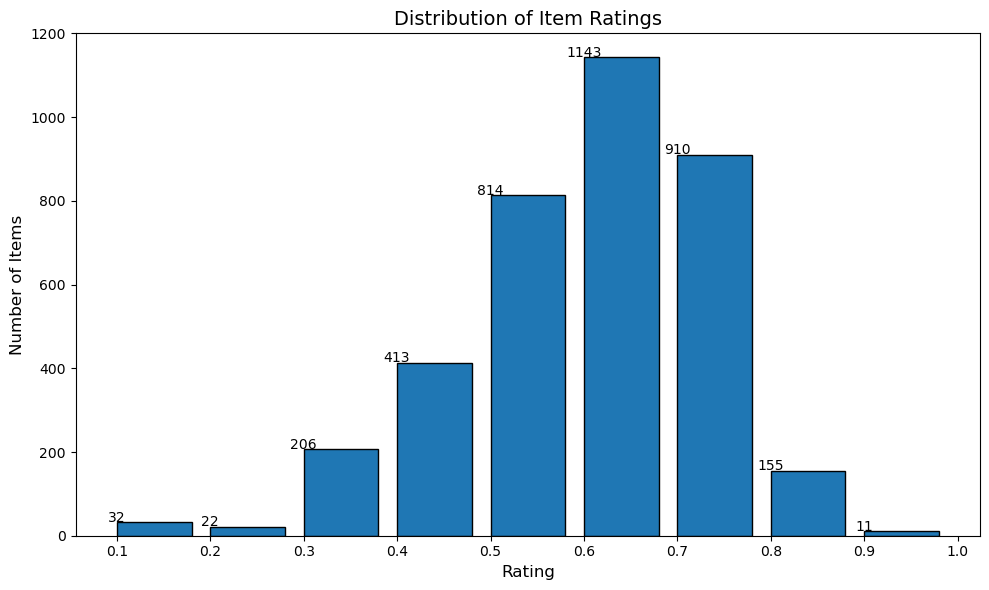

In [6]:
# Extract the ratings from the rankings
ratings = list(rankings.values())

# Define bins for the ratings (from 0.1 to 1.0 with steps of 0.1)
bins = np.arange(0.1, 1.1, 0.1)

# Count how many items fall into each rating bin
hist, bin_edges = np.histogram(ratings, bins=bins)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=0.08, align='edge', edgecolor='black')

# Adding numbers on top of bars
for i in range(len(hist)):
    plt.text(bin_edges[i], hist[i] + 1, str(hist[i]), ha='center', fontsize=10)

# Finalize the plot
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)
plt.title('Distribution of Item Ratings', fontsize=14)
plt.xticks(bins)  # Ensure the x-ticks correspond to the rating bins
plt.tight_layout()
plt.show()


**6. Demographics**

In [7]:
from collections import defaultdict

# Define age ranges with lambda checks
age_ranges = {
    "< 18": lambda age: age < 18,
    "18-24": lambda age: 18 <= age <= 24,
    "25-34": lambda age: 25 <= age <= 34,
    "35-44": lambda age: 35 <= age <= 44,
    "45-54": lambda age: 45 <= age <= 54,
    ">= 55": lambda age: age >= 55,
}

# Initialize dictionaries with sets as default values
gender_groups = defaultdict(set)
age_groups = defaultdict(set)

file_path = "/home/martimsbaltazar/Desktop/tese/datasets/ml-1m/users.dat"

with open(file_path, 'r') as file:
    for line in file:
        # Strip newline and split using the '::' delimiter
        parts = line.strip().split("::")
        if len(parts) != 5:
            continue  # Skip malformed lines

        user_id, gender, age_str, _, _ = parts

        user_id = int(user_id)
        age = int(age_str)

        # Match age to a range label
        for label, condition in age_ranges.items():
            if condition(age):
                age_groups[label].add(user_id)
                break  # Stop once matched

        # Gender grouping
        gender_groups[gender].add(user_id)

# Example: Print sizes of each group
print(f"Gender Groups: {gender_groups}") 

print(f"\nAge Groups: {age_groups}")


Gender Groups: defaultdict(<class 'set'>, {'F': {1, 6, 10, 11, 16, 18, 24, 28, 30, 32, 34, 37, 38, 41, 45, 50, 51, 55, 59, 62, 67, 69, 72, 75, 78, 79, 81, 83, 86, 88, 89, 92, 96, 97, 98, 99, 101, 106, 114, 119, 122, 127, 133, 137, 139, 140, 146, 151, 156, 159, 162, 164, 167, 168, 171, 175, 176, 183, 184, 187, 193, 194, 196, 200, 201, 203, 210, 213, 219, 221, 224, 233, 238, 242, 246, 249, 253, 262, 263, 265, 268, 277, 281, 285, 288, 289, 290, 294, 298, 305, 310, 312, 313, 314, 315, 318, 319, 325, 334, 340, 341, 343, 346, 347, 353, 358, 361, 364, 365, 372, 373, 374, 378, 379, 382, 383, 387, 388, 399, 400, 410, 411, 415, 417, 418, 421, 428, 430, 434, 446, 447, 455, 459, 464, 467, 468, 470, 473, 475, 480, 484, 487, 494, 497, 499, 500, 507, 511, 516, 517, 518, 519, 520, 527, 528, 531, 541, 546, 548, 556, 559, 561, 568, 569, 573, 576, 583, 584, 588, 590, 593, 594, 596, 601, 602, 603, 605, 606, 617, 619, 625, 628, 629, 630, 634, 641, 642, 648, 655, 656, 657, 658, 659, 663, 666, 668, 687, 689,

**7. Metrics**


**7.1   Effectiveness**

In [13]:
def compute_aggregated_average_ranking(df):
    return df.groupby("MovieID")["NormalizedRating"].mean().to_dict()

def compute_kendall_tau(ranking_1, ranking_2):
    common_items = set(ranking_1.keys()) & set(ranking_2.keys())  # Ensure only common items are compared
    
    if len(common_items) < 2:  # Need at least two rankings to compute Kendall's tau
        return 0
    
    sorted_items = sorted(common_items)  # Sort items to ensure consistent order
    
    list_1 = [ranking_1[item] for item in sorted_items]
    list_2 = [ranking_2[item] for item in sorted_items]
    
    return kendalltau(list_1, list_2).correlation

# Compute the aggregated average ranking
aa_rankings = compute_aggregated_average_ranking(df)

# Compute Kendall’s tau for the entire dataset
tau_value = compute_kendall_tau(rankings, aa_rankings)
print(f"Kendall’s τ: {tau_value:.4f}")



Kendall’s τ: 0.9921


**6.2   Bias**

In [22]:
def demographic_reputation_gap(group_users, user_reputations):
    target_users = group_users & all_users
    complementary_users = all_users - target_users

    target_reps = [user_reputations[u] for u in target_users]
    comp_reps = [user_reputations[u] for u in complementary_users]

    target_avg = sum(target_reps) / len(target_reps) if target_reps else 0
    comp_avg = sum(comp_reps) / len(comp_reps) if comp_reps else 0

    return target_avg - comp_avg

# --------------------------------------------------
# GENDER GROUP GAPS
print("=== Gender-Based Reputation Gaps ===")
gap = demographic_reputation_gap(gender_groups["F"], userReputation)
print(f"Reputation gap (Female vs rest): {gap:.4f}")
gap = demographic_reputation_gap(gender_groups["M"], userReputation)
print(f"Reputation gap (Male vs rest): {gap:.4f}")


# --------------------------------------------------
# AGE GROUP GAPS
print("\n=== Age-Based Reputation Gaps ===")
gap = demographic_reputation_gap(age_groups["< 18"], userReputation)
print(f"Reputation gap (< 18 vs rest): {gap:.4f}")
gap = demographic_reputation_gap(age_groups["18-24"], userReputation)
print(f"Reputation gap (18-24 vs rest): {gap:.4f}")
gap = demographic_reputation_gap(age_groups["25-34"], userReputation)
print(f"Reputation gap (25-34 vs rest): {gap:.4f}")
gap = demographic_reputation_gap(age_groups["35-44"], userReputation)
print(f"Reputation gap (35-44 vs rest): {gap:.4f}")
gap = demographic_reputation_gap(age_groups["45-54"], userReputation)
print(f"Reputation gap (45-54 vs rest): {gap:.4f}")
gap = demographic_reputation_gap(age_groups[">= 55"], userReputation)
print(f"Reputation gap (>= 55 vs rest): {gap:.4f}")


=== Gender-Based Reputation Gaps ===
Reputation gap (Female vs rest): -0.0018
Reputation gap (Male vs rest): 0.0018

=== Age-Based Reputation Gaps ===
Reputation gap (< 18 vs rest): -0.0086
Reputation gap (18-24 vs rest): -0.0032
Reputation gap (25-34 vs rest): 0.0009
Reputation gap (35-44 vs rest): 0.0019
Reputation gap (45-54 vs rest): 0.0013
Reputation gap (>= 55 vs rest): 0.0014
